Елисеева Ирина

Февраль 2019 лайт

8-903-797-48-67 eliseeva.irina@bk.ru

## Загрузка

In [ ]:
import importlib.util, sys, gdown

In [ ]:
url = 'https://storage.googleapis.com/aiu_bucket/data.zip'
output = 'data.zip' # Указываем имя файла, в который сохраняем файл
gdown.download(url, output, quiet=True) # Скачиваем файл по указанному URL

'data.zip'

In [ ]:
!unzip -q data.zip -d ''

## Основной блок

In [ ]:
import utils # Подключаем набор функций

**Загрузка данных**

In [ ]:
train_dataset, val_dataset = utils.getData() # Загружаем обучающий и проверочный датасет

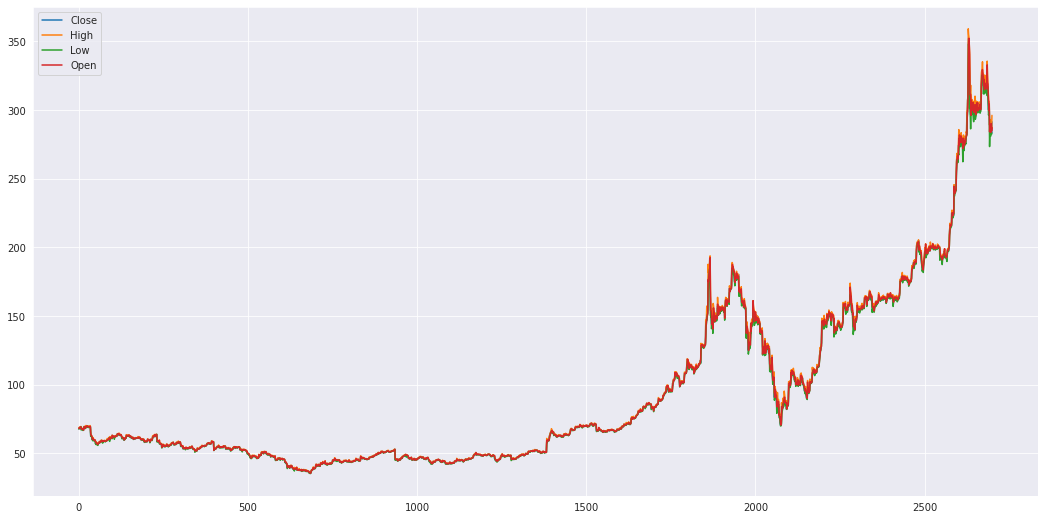

In [ ]:
utils.show_data(train_dataset, start=0, end=0, param=['Close','High','Low','Open']) # Визуализируем обучающий датасет

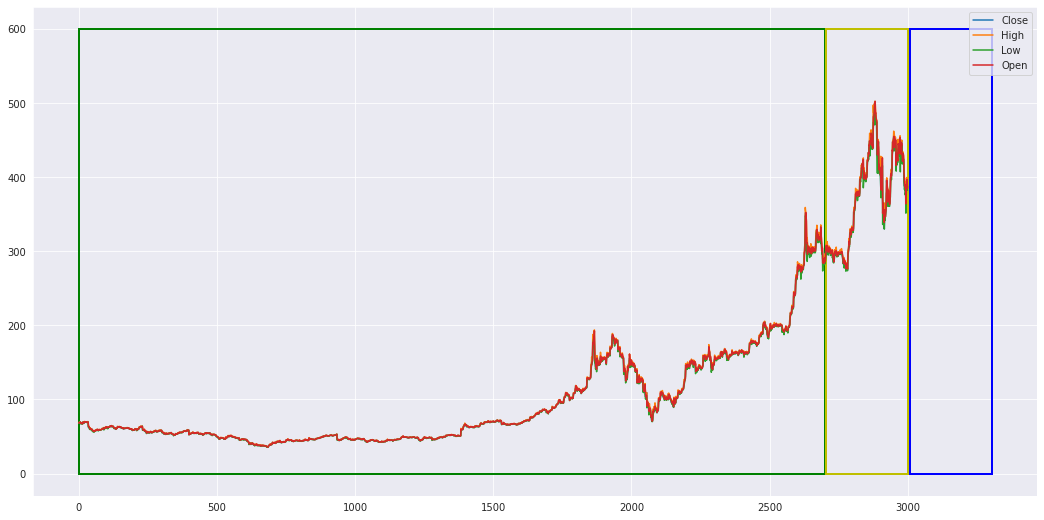

In [ ]:
utils.show_full_data(train_dataset, val_dataset, param=['Close','High','Low','Open'])

**Блок создания нейронной сети**

In [ ]:
data = train_dataset.append(val_dataset).reset_index(drop=True) # добавить датасет, которого сеть не видела

In [ ]:
step_in_the_last = 29   # По скольким шагам в прошлое определяем тренд     
n_steps = 45            # Серию из скольки баров назад анализируем         
forvard_lag = 1         # Предсказание какого бара в будущем делаем      
plato = 0.00            # Какой разброс цены считать "плато" и приравнивать к 0 в ohe при разметке Y 
analyze_period = 2700   # Сколько баров в прошлое берем для тренировки модели (чтобы избежать тренировки на другой динамике рынка) 

In [ ]:
# считаем относительную доходность в единицах на step_in_the_last шагов назад
for i in range(1, step_in_the_last + 1):
    indicator_name = 'Close_chng_%d' % (i)
    data[indicator_name] = data['Close'].pct_change(i) # относительная доходность в единицах

data = data.dropna() # удаляем строки с NaN
print(data.shape)
data[-5:]

(2971, 34)


,Open,High,Low,Close,Volume,Close_chng_1,Close_chng_2,Close_chng_3,Close_chng_4,Close_chng_5,Close_chng_6,Close_chng_7,Close_chng_8,Close_chng_9,Close_chng_10,Close_chng_11,Close_chng_12,Close_chng_13,Close_chng_14,Close_chng_15,Close_chng_16,Close_chng_17,Close_chng_18,Close_chng_19,Close_chng_20,Close_chng_21,Close_chng_22,Close_chng_23,Close_chng_24,Close_chng_25,Close_chng_26,Close_chng_27,Close_chng_28,Close_chng_29
2995,387.010101,398.899994,387.000000,394.410614,14680932,0.019096,0.060134,0.036863,0.032570,0.024563,0.012503,0.017404,0.009523,-0.018977,-0.069729,-0.067011,-0.083190,-0.086793,-0.078178,-0.063803,-0.078594,-0.122381,-0.114990,-0.108515,-0.113774,-0.118005,-0.092057,-0.084193,-0.105584,-0.117571,-0.106050,-0.087754,-0.104630,-0.111693
2996,394.404999,397.640015,386.540100,396.862488,10451084,0.006217,0.025431,0.066725,0.043308,0.038989,0.030932,0.018798,0.023729,0.015799,-0.012878,-0.063946,-0.061211,-0.077491,-0.081116,-0.072448,-0.057983,-0.072866,-0.116926,-0.109489,-0.102973,-0.108265,-0.112522,-0.086412,-0.078500,-0.100024,-0.112085,-0.100493,-0.082083,-0.099064
2997,396.899994,399.500000,390.049988,392.859894,9406746,-0.010086,-0.003932,0.015089,0.055966,0.032786,0.028510,0.020535,0.008523,0.013404,0.005554,-0.022834,-0.073387,-0.070679,-0.086795,-0.090383,-0.081803,-0.067483,-0.082217,-0.125832,-0.118470,-0.112021,-0.117259,-0.121473,-0.095626,-0.087794,-0.109101,-0.121040,-0.109565,-0.091341
2998,392.929993,396.200012,382.424988,384.510010,10206384,-0.021254,-0.031125,-0.025102,-0.006485,0.033522,0.010835,0.006650,-0.001156,-0.012913,-0.008135,-0.015818,-0.043603,-0.093081,-0.090431,-0.106204,-0.109716,-0.101318,-0.087303,-0.101724,-0.144412,-0.137206,-0.130894,-0.136020,-0.140145,-0.114848,-0.107182,-0.128036,-0.139722,-0.128490
2999,384.661407,392.459991,382.250000,387.649994,6194649,0.008166,-0.013261,-0.023213,-0.017141,0.001628,0.041962,0.019090,0.014871,0.007001,-0.004852,-0.000035,-0.007781,-0.035792,-0.085675,-0.083003,-0.098905,-0.102446,-0.093979,-0.079850,-0.094388,-0.137425,-0.130160,-0.123796,-0.128965,-0.133123,-0.107620,-0.099891,-0.120915,-0.132696


In [ ]:
# Добавляем разметку как в Y, но со сдвигом на тренд
for i in range(1, step_in_the_last + 1):
    indicator_name = 'Close_chng_%d' % (i)
    indicator_name_new = 'Y_%d' % (i)
    data[indicator_name_new] = 0
    data.loc[data[indicator_name] > (0 + plato), indicator_name_new] = 1

print(data.shape)
data[-5:]

(2971, 63)


,Open,High,Low,Close,Volume,Close_chng_1,Close_chng_2,Close_chng_3,Close_chng_4,Close_chng_5,Close_chng_6,Close_chng_7,Close_chng_8,Close_chng_9,Close_chng_10,Close_chng_11,Close_chng_12,Close_chng_13,Close_chng_14,Close_chng_15,Close_chng_16,Close_chng_17,Close_chng_18,Close_chng_19,Close_chng_20,Close_chng_21,Close_chng_22,Close_chng_23,Close_chng_24,Close_chng_25,Close_chng_26,Close_chng_27,Close_chng_28,Close_chng_29,Y_1,Y_2,Y_3,Y_4,Y_5,Y_6,Y_7,Y_8,Y_9,Y_10,Y_11,Y_12,Y_13,Y_14,Y_15,Y_16,Y_17,Y_18,Y_19,Y_20,Y_21,Y_22,Y_23,Y_24,Y_25,Y_26,Y_27,Y_28,Y_29
2995,387.010101,398.899994,387.000000,394.410614,14680932,0.019096,0.060134,0.036863,0.032570,0.024563,0.012503,0.017404,0.009523,-0.018977,-0.069729,-0.067011,-0.083190,-0.086793,-0.078178,-0.063803,-0.078594,-0.122381,-0.114990,-0.108515,-0.113774,-0.118005,-0.092057,-0.084193,-0.105584,-0.117571,-0.106050,-0.087754,-0.104630,-0.111693,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2996,394.404999,397.640015,386.540100,396.862488,10451084,0.006217,0.025431,0.066725,0.043308,0.038989,0.030932,0.018798,0.023729,0.015799,-0.012878,-0.063946,-0.061211,-0.077491,-0.081116,-0.072448,-0.057983,-0.072866,-0.116926,-0.109489,-0.102973,-0.108265,-0.112522,-0.086412,-0.078500,-0.100024,-0.112085,-0.100493,-0.082083,-0.099064,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2997,396.899994,399.500000,390.049988,392.859894,9406746,-0.010086,-0.003932,0.015089,0.055966,0.032786,0.028510,0.020535,0.008523,0.013404,0.005554,-0.022834,-0.073387,-0.070679,-0.086795,-0.090383,-0.081803,-0.067483,-0.082217,-0.125832,-0.118470,-0.112021,-0.117259,-0.121473,-0.095626,-0.087794,-0.109101,-0.121040,-0.109565,-0.091341,0,0,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2998,392.929993,396.200012,382.424988,384.510010,10206384,-0.021254,-0.031125,-0.025102,-0.006485,0.033522,0.010835,0.006650,-0.001156,-0.012913,-0.008135,-0.015818,-0.043603,-0.093081,-0.090431,-0.106204,-0.109716,-0.101318,-0.087303,-0.101724,-0.144412,-0.137206,-0.130894,-0.136020,-0.140145,-0.114848,-0.107182,-0.128036,-0.139722,-0.128490,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2999,384.661407,392.459991,382.250000,387.649994,6194649,0.008166,-0.013261,-0.023213,-0.017141,0.001628,0.041962,0.019090,0.014871,0.007001,-0.004852,-0.000035,-0.007781,-0.035792,-0.085675,-0.083003,-0.098905,-0.102446,-0.093979,-0.079850,-0.094388,-0.137425,-0.130160,-0.123796,-0.128965,-0.133123,-0.107620,-0.099891,-0.120915,-0.132696,1,0,0,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### Вычисление направления движения Close как ohe

In [ ]:
# Маркируем направление движения
indicator_name = 'Close_chng_%d' % (step_in_the_last)

a = data[data[indicator_name] < -plato]
a.loc[:, indicator_name] = 0
a.rename(columns = {indicator_name: 'Down'}, inplace=True)

b = data[data[indicator_name] >= -plato]
b.loc[:, indicator_name] = 0
b.rename(columns = {indicator_name: 'Stay'}, inplace=True)

c = data[data[indicator_name] > plato]
c.loc[:, indicator_name] = 1
c.rename(columns = {indicator_name: 'Up'}, inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_g

In [ ]:
import pandas as pd

data_UpDown = pd.concat([a['Down'], b['Stay'], c['Up']], axis=1)
data_UpDown = data_UpDown.fillna(0)
data_UpDown['Y'] = data_UpDown['Down'] + data_UpDown['Stay'] + data_UpDown['Up']
print(data_UpDown.shape)
data_UpDown[-105:-100]

(2971, 4)


,Down,Stay,Up,Y
2895,0.0,0.0,0.0,0.0
2896,0.0,0.0,0.0,0.0
2897,0.0,0.0,0.0,0.0
2898,0.0,0.0,0.0,0.0
2899,0.0,0.0,0.0,0.0


In [ ]:
# удаляем лишнее
del data_UpDown['Down'], data_UpDown['Stay'], data_UpDown['Up']
print(data_UpDown.shape)
data_UpDown[-5:]

(2971, 1)


,Y
2995,0.0
2996,0.0
2997,0.0
2998,0.0
2999,0.0


In [ ]:
# преводим в to_categorical
from keras.utils import to_categorical
categorical_labels = to_categorical(data_UpDown, num_classes = 2)
print(len(categorical_labels))
categorical_labels[-5:]

2971


array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

### Делим на выборки

In [ ]:
for i in range(1, step_in_the_last + 1):
    indicator_name = 'Close_chng_%d' % (i)
    del data[indicator_name]

del data['Open'], data['High'], data['Low'], data['Volume']

print(data.shape)
data[-5:]

(2971, 30)


,Close,Y_1,Y_2,Y_3,Y_4,Y_5,Y_6,Y_7,Y_8,Y_9,Y_10,Y_11,Y_12,Y_13,Y_14,Y_15,Y_16,Y_17,Y_18,Y_19,Y_20,Y_21,Y_22,Y_23,Y_24,Y_25,Y_26,Y_27,Y_28,Y_29
2995,394.410614,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2996,396.862488,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2997,392.859894,0,0,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2998,384.510010,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2999,387.649994,1,0,0,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
data = data.values
print(data.shape, type(data))

(2971, 30) <class 'numpy.ndarray'>


In [ ]:
from scipy.interpolate import CubicSpline # для того, чтобы деформировать
import numpy as np

In [ ]:
sigma=0.05
# функции зашумления данных для создания тестовой выборки (не потребуется при тестировании на выборке УИИ)
def DA_Jitter(X, sigma=0.05):
    myNoise = np.random.normal(loc=0, scale=sigma, size=X.shape)
    return X+myNoise

sigma = 0.1
def DA_Scaling(X, sigma=0.1):
    scalingFactor = np.random.normal(loc=1.0, scale=sigma, size=(1,X.shape[1])) # shape=(1,3)
    myNoise = np.matmul(np.ones((X.shape[0],1)), scalingFactor)
    return X*myNoise

In [ ]:
n_train = 300
xTrain = data[:-n_train]
xTest = data[-n_train:]
yTrain = categorical_labels[:-n_train]
yTest = categorical_labels[-n_train:]

xVal = data[2530:]
xVal = DA_Scaling(DA_Jitter(xVal, sigma)) # аугментируем данные для создания уникального набора данных, которого сеть не видела
yVal = categorical_labels[2530:]
yVal = DA_Scaling(DA_Jitter(yVal, sigma)) # аугментируем данные

print('xTrain: ', xTrain.shape, '\tyTrain:', yTrain.shape,
      '\nxTest:  ', xTest.shape, '\tyTest: ', yTest.shape,
      '\nxVal:   ', xVal.shape, '\tyVal:  ', yVal.shape)
xTrain.shape[0]+xTest.shape[0]+xVal.shape[0]

xTrain:  (2671, 30) 	yTrain: (2671, 2) 
xTest:   (300, 30) 	yTest:  (300, 2) 
xVal:    (441, 30) 	yVal:   (441, 2)


3412

In [ ]:
data[-n_train:][-1] # последняя подаваемая строка

array([387.6499939,   1.       ,   0.       ,   0.       ,   0.       ,
         1.       ,   1.       ,   1.       ,   1.       ,   1.       ,
         0.       ,   0.       ,   0.       ,   0.       ,   0.       ,
         0.       ,   0.       ,   0.       ,   0.       ,   0.       ,
         0.       ,   0.       ,   0.       ,   0.       ,   0.       ,
         0.       ,   0.       ,   0.       ,   0.       ,   0.       ])

### Масштабирование

In [ ]:
from sklearn.preprocessing import RobustScaler

xScaler = RobustScaler()
xScaler.fit(xTrain)
xTrain = xScaler.transform(xTrain)
xTest = xScaler.transform(xTest)
xVal = xScaler.transform(xVal)

print(xTrain.shape, xTest.shape, xVal.shape, type(xTrain))
xTest[-1:]

(2671, 30) (300, 30) (441, 30) <class 'numpy.ndarray'>


array([[ 3.99027081,  0.        , -1.        , -1.        , -1.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        -1.        , -1.        , -1.        , -1.        , -1.        ,
        -1.        , -1.        , -1.        , -1.        , -1.        ,
        -1.        , -1.        , -1.        , -1.        , -1.        ,
        -1.        , -1.        , -1.        , -1.        , -1.        ]])

In [ ]:
# проверяем обратную трансформацию
x = xScaler.inverse_transform(xTest[-1:])
x[-1][0]

387.6499938964844

### Превращение в TimeSeries

In [ ]:
# sequence = строка массива данных
# n_steps = число баров в прошлом для анализа
# forvard_lag = предсказание какого бара в будущем делаем 

def split_sequence(sequence, Y, n_steps, forvard_lag):
    # sequence - массив из данных
    # n_steps - число баров в прошлом для анализа
    X, y = list(), list()
    for i in range(len(sequence)):
        end_ix = i + n_steps # находим конечный индекс строки
        if end_ix + (forvard_lag-1) > len(sequence)-1: # проверяем пределы массива
          break 
        # получаем X и y
        seq_x, seq_y = sequence[i:end_ix], Y[end_ix + (forvard_lag - 1)]
        X.append(seq_x)
        y.append(seq_y) # предсказываем только Close
    return array(X), array(y)

In [ ]:
from numpy import array
# Формируем выборки для обучения нейросети
xTrain, yTrain = split_sequence(xTrain, yTrain, n_steps, forvard_lag)
print('Массивы xTrain и yTrain:\t', xTrain.shape, yTrain.shape)

Массивы xTrain и yTrain:	 (2626, 45, 30) (2626, 2)


In [ ]:
# Формируем выборки для обучения нейросети
xTest, yTest = split_sequence(xTest, yTest, n_steps, forvard_lag)
print('Массивы xTest и yTest:\t', xTest.shape, yTest.shape)

Массивы xTest и yTest:	 (255, 45, 30) (255, 2)


In [ ]:
# Формируем выборки для нейросети
xVal, yVal = split_sequence(xVal, yVal, n_steps, forvard_lag)
print('Массивы xVal и yVal:\t', xVal.shape, yVal.shape)

Массивы xVal и yVal:	 (396, 45, 30) (396, 2)


In [ ]:
close = xScaler.inverse_transform(xTest[-1])
close[-1][0], yTest[-1]

(384.510009765625, array([1., 0.], dtype=float32))

### Колбэки

In [ ]:
import matplotlib.pyplot as plt
import keras

from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import (concatenate, Input, Dense, Dropout, BatchNormalization, Flatten, 
                                     GRU, LSTM, Bidirectional, Conv1D, SeparableConv1D, MaxPooling1D,
                                     Reshape, RepeatVector, SpatialDropout1D, LeakyReLU, Embedding)
from tensorflow.keras.optimizers import Adam, Nadam, RMSprop, Adamax
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras import utils
from keras.utils import plot_model
from IPython.display import clear_output

from keras.callbacks import ModelCheckpoint,EarlyStopping,TensorBoard,CSVLogger,ReduceLROnPlateau,LearningRateScheduler
from IPython.display import clear_output

In [ ]:
# коллбэки
early_stopping = EarlyStopping(monitor = 'val_binary_accuracy', patience = 20, verbose = 1, 
                               restore_best_weights = True, mode='max')
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor=0.9, patience=5, min_lr=1e-04, verbose = 1)
checkpoint = ModelCheckpoint('LSTM.h5', monitor='val_binary_accuracy', verbose = 1,
                             save_best_only = True, mode='max')

####################################
# колбек, показывающий на графике изменяющиеся на каждой эпохе значения точности и потерь
####################################

# События будут сохранены в файле. / log, который является папкой, используемой tensorboard для извлечения данных
tbCallBack = TensorBoard(log_dir='./log', histogram_freq=1,                 
                         write_graph=True,                                  
                         write_images=True,
                         )

class PlotLearning(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('binary_accuracy'))
        self.val_acc.append(logs.get('val_binary_accuracy'))
        self.i += 1
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(18,7), sharex=True)
        
        clear_output(wait=True)

        ax1.set_yscale('log')
        ax1.plot(self.x, self.losses, label="loss")
        ax1.plot(self.x, self.val_losses, label="val_loss")
        ax1.legend()
        
        ax2.plot(self.x, self.acc, label="binary_accuracy")
        ax2.plot(self.x, self.val_acc, label="val_binary_accuracy")
        ax2.legend()
        
        plt.show();
        
plot = PlotLearning()

class PlotLosses(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i += 1
        
        clear_output(wait=True)
        plt.plot(self.x, self.losses, label="loss")
        plt.plot(self.x, self.val_losses, label="val_loss")
        plt.legend()
        plt.show()
        
plot_losses = PlotLosses()

callbacksList=[plot_losses,plot,tbCallBack]

### Нейросеть

In [ ]:
'Conv1D_LSTM'
model = Sequential()
model.add(Conv1D(512, 9, activation='tanh', padding='same', input_shape = (xTrain.shape[1], xTrain.shape[2])))
model.add(SpatialDropout1D(0.7)) 

model.add(Conv1D(512, 8, activation="tanh", padding='same')) 
model.add(LSTM(512, return_sequences=1))        

model.add(Conv1D(512, 8, activation="tanh", padding='same')) 
model.add(LSTM(512, return_sequences=1))         

model.add(Flatten())                             
model.add(Dense(1024, activation='relu'))

model.add(Dense(yTrain.shape[1], activation='softmax'))

model.compile(optimizer=Adam(learning_rate = 1e-03),
              loss='binary_crossentropy',
              metrics=['binary_accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_3 (Conv1D)            (None, 45, 512)           138752    
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 45, 512)           0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 45, 512)           2097664   
_________________________________________________________________
lstm_2 (LSTM)                (None, 45, 512)           2099200   
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 45, 512)           2097664   
_________________________________________________________________
lstm_3 (LSTM)                (None, 45, 512)           2099200   
_________________________________________________________________
flatten_1 (Flatten)          (None, 23040)            

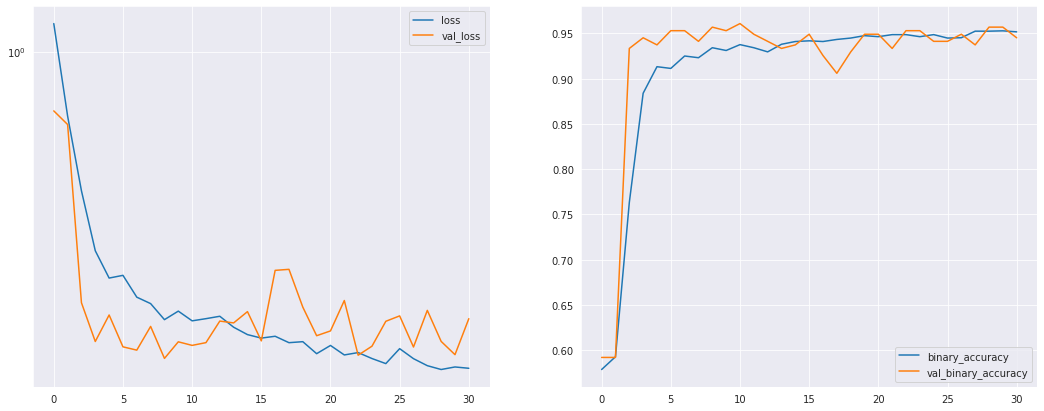

Epoch 00031: early stopping


In [ ]:
history = model.fit(xTrain, yTrain, epochs=100, verbose=1,
                    validation_data=(xTest, yTest),
                    callbacks = [early_stopping, reduce_lr, checkpoint, callbacksList])

In [ ]:
score = model.evaluate(xTest, yTest, verbose=1)
print('Test score:', score[0])
print('Test accuracy:', score[1])

8/8 [==============================] - 0s 17ms/step - loss: 0.1622 - binary_accuracy: 0.9608
Test score: 0.16220679879188538
Test accuracy: 0.9607843160629272


### Моделирование торговли

In [ ]:
from tensorflow.keras.models import load_model

**Блок тестирования модели**

In [ ]:
def trading(model, xTest):
    x_test = xTest
    dataset = pd.DataFrame()
    statement = 0    # 0:выводим деньги, 1:покупаем, 2:продаем
    shares = 0       # Число акций
    money = 100000   # Стартовая сумма капитала
    # -----------------------------------------

    for i in range(len(x_test)):       # Выбираем пример
        x = x_test[i]
        x = np.expand_dims(x, axis=0)
        prediction = model.predict(x)  # Распознаём наш пример  
        signal = np.argmax(prediction) # Получаем индекс самого большого элемента (итог)
        close = xScaler.inverse_transform(x_test[i])
        close = close[-1][0]

        if statement == 0  and  signal == 1:
          statement = 1
          money_history = money//close * close + money - money//close * close
          inv_capital = money//close * close
          line = pd.DataFrame({'statement':[0], 'signal':[signal], 'close':[close],'shares':[money//close], 'deal_prise':[close],
                               'long':[close], 'short':[0], 'inv_capital':[inv_capital], 'money':[money - money//close * close],
                               'money_history':[money_history], 'report':[0]})
          dataset = dataset.append(line, ignore_index=True)
          continue
      
        elif statement == 0  and  signal == 0:
          line = pd.DataFrame({'statement':[statement], 'signal':[signal], 'close':[close],'shares':[0],  'deal_prise':[0],
                               'long':[0], 'short':[0], 'inv_capital':[0], 'money':[money], 'money_history':[money],
                               'report':[0]})
          dataset = dataset.append(line, ignore_index=True)
          continue
          
        elif statement == 1  and  signal == 1:
          shares = dataset.iloc[i-1][3]
          money = dataset.iloc[i-1][8]
          inv_capital = close*shares
          money_history = close*shares+money
          line = pd.DataFrame({'statement':[statement], 'signal':[signal], 'close':[close], 'shares':[shares], 'deal_prise':[dataset.iloc[i-1][4]],
                               'long':[0], 'short':[0], 'inv_capital':[inv_capital], 'money':[money], 'money_history':[money_history], 
                               'report':[0]})
          dataset = dataset.append(line, ignore_index=True)
          continue

        elif statement == 1  and  signal == 0:  
          statement = 0
          shares = dataset.iloc[i-1][3]
          report = (close - dataset.iloc[i-1][4]) * shares
          money_history = close * shares + dataset.iloc[i-1][8]
          shares = 0
          inv_capital = close*shares
          money = money_history - inv_capital
          line = pd.DataFrame({'statement':[1], 'signal':[signal], 'close':[close], 'shares':[shares], 'deal_prise':[close],
                              'long':[0], 'short':[close], 'inv_capital':[inv_capital], 'money':[money], 'money_history':[money_history],
                              'report':[report]})
          dataset = dataset.append(line, ignore_index=True)
          continue

    return dataset

In [ ]:
def plotting(dataset):
    short = dataset['short'].values
    short = short.astype(bool)
    long = dataset['long'].values
    long = long.astype(bool)
    idx_long = np.where(long) 
    idx_short = np.where(short) 

    plt.figure(figsize=(18,5))

    plt.subplot(121)
    plt.plot(dataset['close'])
    plt.plot(idx_long, dataset['close'].values[[idx_long]], '^', c='g', markersize=8)
    plt.plot(idx_short, dataset['close'].values[[idx_short]], 'v', c='r', markersize=8)
    plt.grid()

    plt.subplot(122)
    plt.plot(dataset['money_history'])
    plt.grid()
    plt.show()

### Моделирование торговли на тестовой выборке в 300 часовых интервалов

Модель Conv1D_LSTM показывает лучшие результаты на отложенной выборке https://drive.google.com/file/d/18LekK4dSo_J-IDKy77LNd2vXa9ZfclAn/view?usp=sharing

В данном блоке результат для конкурса. 

на xTest (300 отсчетов)

Прибыль: 76034.64 руб.

на xVal (470 отчетов - аугментированные путем зашумления данные)

Прибыль: 64428.18 руб.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp -r /content/drive/'MyDrive'/Weights/Conv1D_LSTM.h5 Conv1D_LSTM.h5
!ls

Conv1D_LSTM.h5	log	     sample_data	utils.py
data.zip	LSTM.h5      test_val_LSTM.h5	val_dataset.csv
drive		__pycache__  train_dataset.csv


In [ ]:
file = 'Conv1D_LSTM.h5'
model = load_model(file)
dataset = trading(model, xTest)
dataset['profit'] = dataset['money_history'] - 100000
dataset[-1:] # итоги торговли текущей сети

,statement,signal,close,shares,deal_prise,long,short,inv_capital,money,money_history,report,profit
254,0,0,384.51001,0.0,0.0,0.0,0.0,0.0,176034.641083,176034.641083,0.0,76034.641083


In [ ]:
print('Прибыль: {0:.2f} руб.'.format(dataset['profit'][254]))

Прибыль: 76034.64 руб.


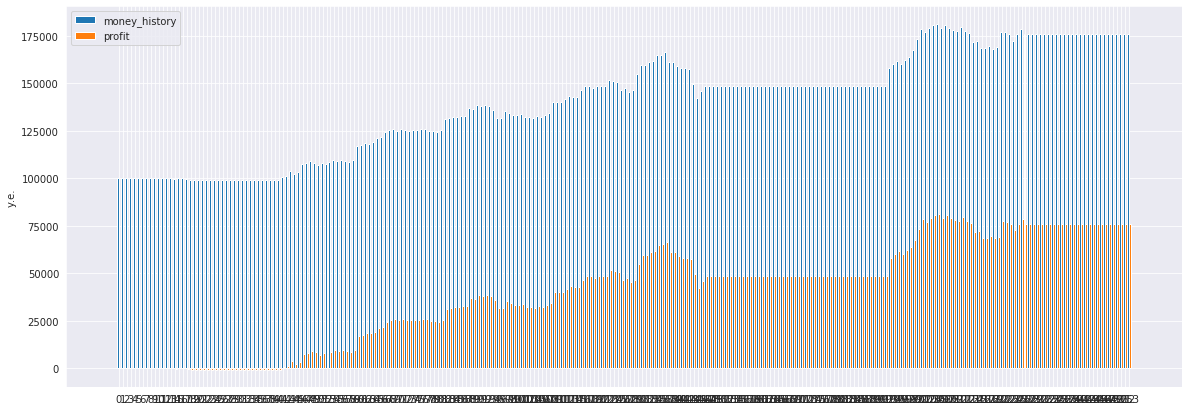

In [ ]:
x = np.arange(len(dataset[:254]))  
width = 0.5

fig, ax = plt.subplots(figsize=(20,7))
rects1 = ax.bar(x - width/2, dataset['money_history'][:254], width, label='money_history')
rects2 = ax.bar(x + width/2, dataset['profit'][:254], width, label='profit')

ax.set_ylabel('у.е.')
ax.set_xticks(x)
ax.legend()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  


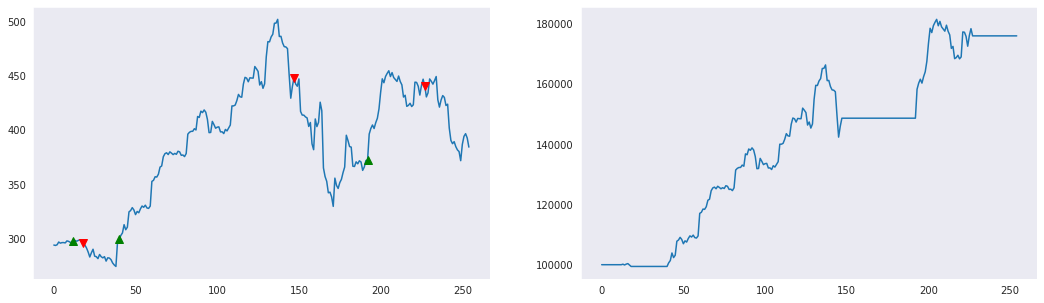

In [ ]:
plotting(dataset)

### Моделирование торговли на отложенной выборке

Судя по графику, тестовая выборка предполагается с небольшим отскоком, но в растущем тренде.

Модель Conv1D_LSTM показывает хорошие результаты на отложенной выборке https://drive.google.com/file/d/18LekK4dSo_J-IDKy77LNd2vXa9ZfclAn/view?usp=sharing

на xVal (470 отчетов - аугментированные путем зашумления данные)

Прибыль: 64428.18 руб.

Модель Conv1D_LSTM_Val также показывает хорошие результаты на отложенной выборке  https://drive.google.com/file/d/1LS1OkXD6N0BwsUsZxM0R5DKwroZoY_kI/view?usp=sharing

на xVal (470 отчетов - аугментированные путем зашумления данные)

Прибыль: 65742.05 руб.

Можно испытать обе модели.

In [ ]:
model = load_model('Conv1D_LSTM.h5') 

dataset = trading(model, xVal) # заменить на нужную выборку
dataset['profit'] = dataset['money_history'] - 100000
dataset[-1:] # итоги торговли текущей сети

,statement,signal,close,shares,deal_prise,long,short,inv_capital,money,money_history,report,profit
395,0,0,391.912586,0.0,0.0,0.0,0.0,0.0,164428.184961,164428.184961,0.0,64428.184961


In [ ]:
print('Прибыль: {0:.2f} руб.'.format(dataset['profit'][395]))

Прибыль: 64428.18 руб.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  


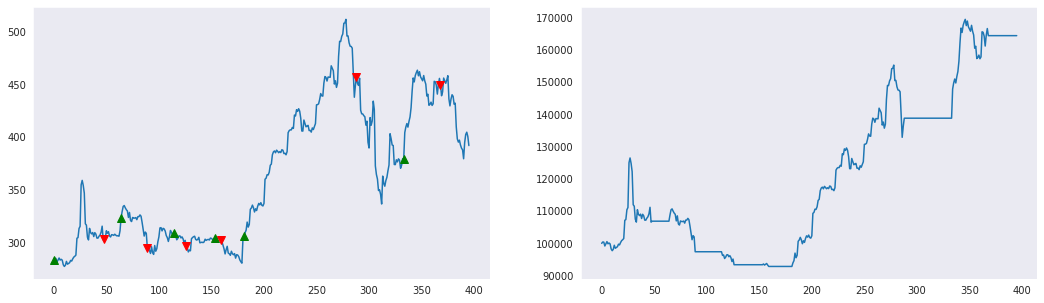

In [ ]:
plotting(dataset) # график торговли

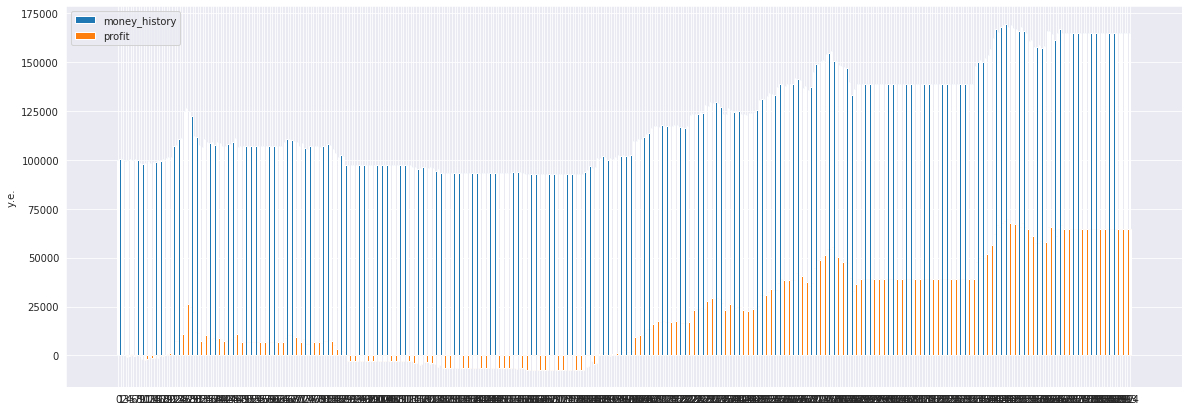

In [ ]:
x = np.arange(len(dataset[:395]))  
width = 0.5

fig, ax = plt.subplots(figsize=(20,7))
rects1 = ax.bar(x - width/2, dataset['money_history'][:395], width, label='money_history')
rects2 = ax.bar(x + width/2, dataset['profit'][:395], width, label='profit')

ax.set_ylabel('у.е.')
ax.set_xticks(x)
ax.legend()

### Для сравнения посмотрим на торговые сигналы, формируемые пересечением двойной скользящей средней.

In [ ]:
val_dataset = val_dataset['Close']

short_window = 10
mid_window = 50

signals = pd.DataFrame(index=val_dataset.index)
signals['signal'] = 0.0

roll_d10 = val_dataset.rolling(window=short_window).mean()
roll_d50 = val_dataset.rolling(window=mid_window).mean()

signals['short_mavg'] = roll_d10
signals['mid_mavg'] = roll_d50
signals['signal'][short_window:] = np.where(signals['short_mavg'][short_window:] 
                                            > signals['mid_mavg'][short_window:], 1.0, 0.0)
signals['positions'] = signals['signal'].diff()

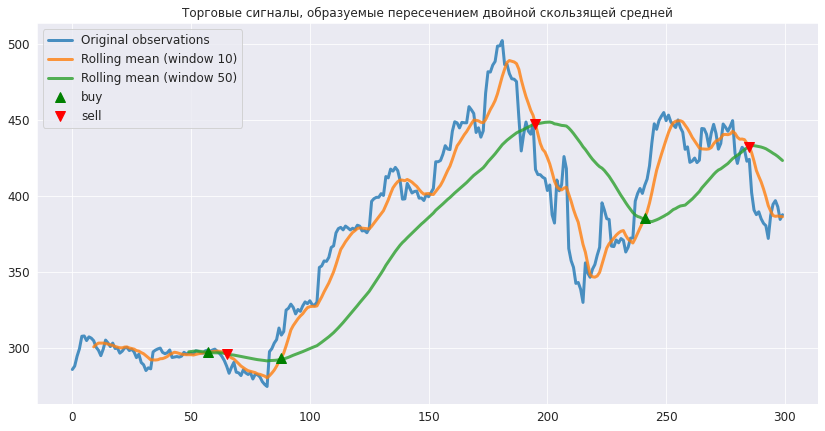

In [ ]:
plt.figure(figsize=(14, 7))
plt.plot(val_dataset.index, val_dataset, lw=3, alpha=0.8,label='Original observations')
plt.plot(val_dataset.index, roll_d10, lw=3, alpha=0.8,label='Rolling mean (window 10)')
plt.plot(val_dataset.index, roll_d50, lw=3, alpha=0.8,label='Rolling mean (window 50)')

plt.plot(signals.loc[signals.positions == 1].index, 
         signals.short_mavg[signals.positions == 1],
         '^', markersize=10, color='g', label='buy')
         
plt.plot(signals.loc[signals.positions == -1].index, 
         signals.short_mavg[signals.positions == -1],
         'v', markersize=10, color='r', label='sell')

plt.title('Торговые сигналы, образуемые пересечением двойной скользящей средней')
plt.tick_params(labelsize=12)
plt.legend(loc='upper left', fontsize=12)
plt.show()